Goals
* Box + vanishing point -> 3D image
* Manual detection of box?
```
─────────────────────────────**──────────
───▐▀▄───────▄▀▌───▄▄▄▄▄▄▄─────────────
───▌▒▒▀▄▄▄▄▄▀▒▒▐▄▀▀▒██▒██▒▀▀▄──────────
──▐▒▒▒▒▀▒▀▒▀▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▀▄────────
──▌▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▄▒▒▒▒▒▒▒▒▒▒▒▒▀▄──────
▀█▒▒▒█▌▒▒█▒▒▐█▒▒▒▀▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌─────
▀▌▒▒▒▒▒▒▀▒▀▒▒▒▒▒▒▀▀▒▒▒▒▒▒▒▒▒▒▒▒▒▒▐───▄▄
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌▄█▒█
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒█▒█▀─
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒█▀───
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌────
─▌▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▐─────
─▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌─────
──▌▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▐──────
──▐▄▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▄▌──────
────▀▄▄▀▀▀▀▀▄▄▀▀▀▀▀▀▀▄▄▀▀▀▀▀▄▄▀────────
```**

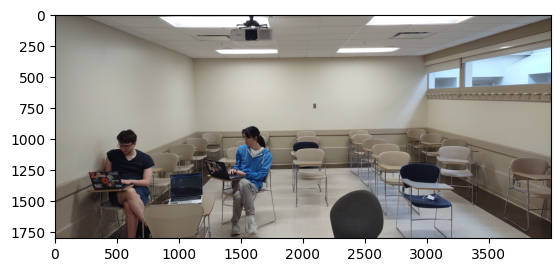

In [ ]:
import numpy as np
import numpy.linalg as la
import cv2
import matplotlib.pyplot as plt

import utils

image = cv2.imread("./pictures/trial_room.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter

plt.imshow(image_rgb)
plt.show()

Computing Homography 

In [ ]:
# box coordinates
box = np.array(((1113, 356), (1113, 1224), (2987, 356), (2987, 1224)))
# [top left] [bottom left] [top right] [bottom right]


# vanishing point the image is a bit offcenter
vp = np.array((1906 , 643))


width_box  = box[2][0] - box[0][0] 
height_box = box[1][1] - box[0][1] 

print(width_box)
print(height_box)

1874
868


Compute Depth

In [3]:
# Computing Depth

fstop = 1.7
focal_length_mm = 5 # TODO use package to auto import from iamges
aperture_diameter_mm = focal_length_mm / fstop


# compute dimensions of box
# f / (va - v0) = d / H
depth = focal_length_mm * height_box / (aperture_diameter_mm / 2)
print(depth) 

2951.2


Compute homography

In [5]:
# compute points for floor
# extend line
alpha = -0.5
bl close_box = vp * alpha + box *(1-alpha)nt(bl,brclose_box

# fov = 2 * np.arctan(depth/(2 * focal_length_mm)) # angle


SyntaxError: invalid syntax (2674438192.py, line 4)

In [ ]:
# homography
# p' = Hp

def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD. Normalization is optional.
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    # TO DO
    # create A
    N = pts1.shape[1]
    A = np.zeros((2*N, 9))
    for i in range(N):
        (u, v) = pts1[:2, i]
        (u_p, v_p) = pts2[:2, i]
        A[2*i, 0] = -u
        A[2*i, 1] = -v
        A[2*i, 2] = -1
        A[2*i, 6] = u*u_p
        A[2*i, 7] = v*u_p
        A[2*i, 8] = u_p
        A[2*i+1, 3] = -u
        A[2*i+1, 4] = -v
        A[2*i+1, 5] = -1
        A[2*i+1, 6] = u*v_p
        A[2*i+1, 7] = v*v_p
        A[2*i+1, 8] = v_p
    # do SVD
    [U, S, V] = svd(A)
    h = V.T[:, -1]
    H = np.reshape(h, (3, 3))

    return H

In [ ]:
# Compute the size of each wall

# Compute Left Side
